# Wrangling of Hot 100 Data

In this initial step I'll merge the raw data scraped from the [Billboard Hot 100 Charts](https://www.billboard.com/charts/hot-100/) with the songs' respective features from the [Spotify API Features Endpoint](https://developer.spotify.com/documentation/web-api/reference/tracks/get-several-audio-features/).


In [155]:
import os
import numpy as np
import pandas as pd
from glob import glob, iglob
import re
import time
from similarity.metric_lcs import MetricLCS # String Similarity https://github.com/luozhouyang/python-string-similarity
from similarity.ngram import NGram

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

GrayO = ["gray","orange","black"]
sns.set_palette(GrayO)

%matplotlib inline
%config InlineBackend.figure_format='retina'

pd.options.display.max_columns = 400

pd.options.display.max_rows = 400

twogram = NGram(2)
metric_lcs = MetricLCS()

In [156]:
# Switch Directory to ../data/interim/
current_dir = os.getcwd()
destination_dir = '/data/interim'
if current_dir[-len(destination_dir):] != destination_dir:
    os.chdir('..' + destination_dir)
else:
    print('already in correct directory: ',current_dir)
    
def switch_dir(data_subdir):
    print('switch to /data/' + data_subdir)
    os.chdir('../' + data_subdir)

already in correct directory:  /Users/sebastian/git_repos/data_science/hit_predictor/data/interim


The scraper has separated each chart into a separate file. These need to be merged into one comprehensive Dataframe. Each file contains 100 tracks.

In [157]:
filenames = glob('hot100/*.csv')
print("There is a total of {} files with 100 songs each.".format(len(filenames)))

target_path = '../interim/hot100_songs.csv'

try:
    # Read in Summary File is exists
    hot100_all = pd.read_csv(target_path,sep='\t',parse_dates=['date'])
except:
    # Read in all Subfiles
    hot100_dfs = [pd.read_csv(filepath,sep='\t',usecols=['date','rank','title','artist'],
                              parse_dates=['date']) for filepath in filenames]
    hot100_all = pd.concat(hot100_dfs)
    
    # Create Summary File for faster processing
    hot100_all.to_csv(target_path,sep='\t',index=False)

print("The total number of songs is {}.".format(len(hot100_all)))
hot100_all.head()

There is a total of 3167 files with 100 songs each.
The total number of songs is 316685.


,rank,date,title,artist
0,1,1967-07-08,Windy,The Association
1,2,1967-07-08,Little Bit O' Soul,The Music Explosion
2,3,1967-07-08,Can't Take My Eyes Off You,Frankie Valli
3,4,1967-07-08,San Francisco (Be Sure To Wear Flowers In Your...,Scott McKenzie
4,5,1967-07-08,Don't Sleep In The Subway,Petula Clark


We can see that 3167 files (100 songs each) shows a total of 15 missing songs. We'll look at those 15 songs further down in this analysis.

Next we'll add a few additional columns to enrich the information by track performance and artist performance:
    - reentry - Multiple non-consecutive listings on the Hot 100
    - streak - Consecutive length a song ranked in the Hot 100
    - ranked - Number of Times a song ranked in the Hot 100
    - leap - The biggest jump in rank from one week to the next
    - entry - Position it first appeared
    - exit - Position it last appeared
    - peak - Highest Position
    - low - Lowest Position

In [158]:
# Split Dates into year, month, day columns
def split_date(df,dt_col,prefix=False):
    """
    This function adds split date columns (year, month, day) to the dataframe. This is an inplace function.
    """
    if prefix:
        prefix = prefix
    else:
        prefix = ''
    df.loc[:,prefix + 'year'] = df.loc[:,dt_col].dt.year
    df.loc[:,prefix + 'month'] = df.loc[:,dt_col].dt.month
    df.loc[:,prefix + 'day'] = df.loc[:,dt_col].dt.day

split_date(hot100_all,'date')
hot100_all = hot100_all.loc[:,['rank','date','year','month','day','title','artist']]

In [159]:
# Continuous or Not?
consecutive = hot100_all.loc[:,['title','artist','date','rank']].sort_values(by=['title','artist','date'])
consecutive['prev_week'] = consecutive.groupby(by=['title','artist']).date.shift()
consecutive['consecutive'] = (consecutive['date'] - consecutive['prev_week']) == '7 days'

## Reentry from consecutive column
reentry = consecutive.loc[:,['artist','title','consecutive']]
reentry = consecutive.loc[consecutive['consecutive'] == False,:].groupby(by=['artist','title']).count()['consecutive'] - 1
reentry = reentry.reset_index().rename(columns={'consecutive':'reentry'})
reentry['reentry'] = reentry['reentry'].astype(int)
reentry.loc[reentry['reentry'] == 0, 'reentry'] = np.nan

hot100_all = hot100_all.merge(reentry,on=['title','artist'],how='left')
reentry = ''

# Streak from consecutive columns
# use cumsum() if consecutive['consecutive'] == True and Reset to 0 if consecutive['consecutive'] == False
streak = consecutive.loc[:,['artist','title','consecutive']].copy()
streak['streak'] = streak.groupby( (streak['consecutive'] != 1).cumsum()).cumcount() + \
                  ( (streak['consecutive'] != 1).cumsum() == 0).astype(int) 
streak = streak.loc[:,['title','artist','streak']].groupby(by=['title','artist']).max().reset_index()

hot100_all = hot100_all.merge(streak,on=['title','artist'],how='left')
streak = ''
consecutive = ''

In [160]:
# Ranked
ranked = hot100_all.loc[:,['title','artist','rank']].groupby(by=['title','artist']).count().reset_index()
ranked.columns = ['title','artist','ranked']

hot100_all = hot100_all.merge(ranked,on=['title','artist'],how='left')
ranked = ''

In [161]:
# Entry
entry_date = hot100_all.loc[:,['title','artist','date']].groupby(by=['title','artist']).min().reset_index()
entry_date.rename(columns={'date': 'entry_date'},inplace=True)
hot100_all = hot100_all.merge(entry_date,on=['title','artist'],how='left')

entry_rank = hot100_all.loc[hot100_all.date == hot100_all.entry_date,['artist','title','rank']]
entry_rank.rename(columns={'rank': 'entry'},inplace=True)

hot100_all = hot100_all.merge(entry_rank,on=['title','artist'],how='left')
entry_date = ''
entry_rank = ''

# Split Entry Date
split_date(hot100_all,'entry_date','entry_')

In [162]:
# Exit
exit_date = hot100_all.loc[:,['title','artist','date']].groupby(by=['title','artist']).max().reset_index()
exit_date.rename(columns={'date': 'exit_date'},inplace=True)
hot100_all = hot100_all.merge(exit_date,on=['title','artist'],how='left')

exit_rank = hot100_all.loc[hot100_all.date == hot100_all.exit_date,['artist','title','rank']]
exit_rank.rename(columns={'rank': 'exit'},inplace=True)

hot100_all = hot100_all.merge(exit_rank,on=['title','artist'],how='left')
exit_date = ''
exit_rank = ''

# Split Exit Date
split_date(hot100_all,'exit_date','exit_')

In [163]:
# Peak
peak = hot100_all.loc[:,['title','artist','rank']].groupby(by=['title','artist']).min().reset_index()
peak.columns = ['title','artist','peak']
hot100_all = hot100_all.merge(peak,on=['title','artist'],how='left')

first_peak = hot100_all.merge(peak,on=['title','artist'],how='left').sort_values(by='date')\
                .drop_duplicates(subset=['title','artist'],keep='first')
first_peak = first_peak.loc[:,['title','artist','date']]
first_peak.rename(columns={'date': 'peak_date'},inplace=True)

hot100_all = hot100_all.merge(first_peak,on=['title','artist'],how='left')
peak = ''

# Split Peak Date
split_date(hot100_all,'peak_date','peak_')

In [164]:
# Leap
jump = hot100_all.loc[:,['artist','title','date','rank']].sort_values(by=['artist','title','date'])
jump['prev_rank'] = jump.groupby(by=['artist','title'])['rank'].shift()
jump['leap'] = (jump['prev_rank'] - jump['rank'])
jump.fillna(-1,inplace=True)
jump.set_index(['artist','title'],inplace=True)

# Max Leap
max_leap = jump.groupby(by=['artist','title'])['leap'].max()
jump['max_leap'] = max_leap

# Max leap date
jump.loc[jump['leap'] == jump['max_leap'],'max_leap_date']= jump.loc[jump['leap'] == jump['max_leap'],'date']
jump['max_leap_date'] = jump.groupby(by=['artist','title']).max_leap_date.transform(lambda x: x.min())

jump = jump.drop(['prev_rank'], axis=1)

hot100_all = hot100_all.merge(jump,on=['title','artist','date','rank'],how='left')

jump = ''
# Split Exit Date
split_date(hot100_all,'max_leap_date','max_leap_')

In [165]:
# Low
low = hot100_all.loc[:,['title','artist','rank']].groupby(by=['title','artist']).max().reset_index()
low.columns = ['title','artist','low']
hot100_all = hot100_all.merge(low,on=['title','artist'],how='left')

In [166]:
processed_path = '../processed/'
hot100_target = 'hot100.csv'
hot100_all.to_csv(processed_path + hot100_target,sep='\t',index=False,encoding='utf-8')

hot100_all.head()

,rank,date,year,month,day,title,artist,reentry,streak,ranked,entry_date,entry,entry_year,entry_month,entry_day,exit_date,exit,exit_year,exit_month,exit_day,peak,peak_date,peak_year,peak_month,peak_day,leap,max_leap,max_leap_date,max_leap_year,max_leap_month,max_leap_day,low
0,1,1967-07-08,1967,7,8,Windy,The Association,NaN,13,14,1967-05-27,52,1967,5,27,1967-08-26,34,1967,8,26,1,1967-05-27,1967,5,27,0.0,24.0,1967-06-03,1967,6,3,52
1,2,1967-07-08,1967,7,8,Little Bit O' Soul,The Music Explosion,NaN,15,16,1967-05-13,90,1967,5,13,1967-08-26,46,1967,8,26,2,1967-05-13,1967,5,13,1.0,33.0,1967-05-27,1967,5,27,90
2,3,1967-07-08,1967,7,8,Can't Take My Eyes Off You,Frankie Valli,NaN,15,16,1967-05-20,74,1967,5,20,1967-09-02,35,1967,9,2,2,1967-05-20,1967,5,20,4.0,21.0,1967-05-27,1967,5,27,74
3,4,1967-07-08,1967,7,8,San Francisco (Be Sure To Wear Flowers In Your...,Scott McKenzie,NaN,11,12,1967-05-27,98,1967,5,27,1967-08-12,28,1967,8,12,4,1967-05-27,1967,5,27,0.0,43.0,1967-06-03,1967,6,3,98
4,5,1967-07-08,1967,7,8,Don't Sleep In The Subway,Petula Clark,NaN,9,10,1967-06-03,76,1967,6,3,1967-08-05,42,1967,8,5,5,1967-06-03,1967,6,3,5.0,27.0,1967-06-10,1967,6,10,76


Read in the spotify ids (created using `make data` in console) as a DataFrame to match with Hot 100 chart set.

In [140]:
# Read in all Subfiles
hot100_ids = pd.read_csv('../iterators/spotify_ids_hot100.csv',sep='\t').drop_duplicates(subset=['iterator'],keep='first')

# remove karaoke artists
cond_not_verified = hot100_ids['verified'] == False
cond = cond_not_verified & hot100_ids['spotify_artist'].str.contains('KARAOKE', flags=re.IGNORECASE)
hot100_ids.loc[cond,['iterator','spotify_artist','spotify_title']] = np.nan

# drop NaN values
hot100_ids = hot100_ids.dropna(subset=['iterator'])

print(len(hot100_ids))
hot100_ids.head()

23859


,iterator,filename,artist,title,spotify_artist,spotify_title,verified
1,59IxJQuFPmW4Xvy7GynZDF,./data/interim/hot100/hot100_1967-07-03.csv,Four Tops,7 Rooms Of Gloom,Four Tops,7-Rooms Of Gloom,False
2,1cmjxqobVTrgAiJ0btAleN,./data/interim/hot100/hot100_1967-07-03.csv,Procol Harum,A Whiter Shade Of Pale,Procol Harum,A Whiter Shade of Pale - Original Single Version,False
3,30nBdjVsKGchhjSy89mv2N,./data/interim/hot100/hot100_1967-07-03.csv,Marvin Gaye & Tammi Terrell,Ain't No Mountain High Enough,Various Artists,Ain't No Mountain High Enough,False
4,5eeZr5k6eprE1NToNTZuxs,./data/interim/hot100/hot100_1967-07-03.csv,Dionne Warwick,Alfie,Dionne Warwick,Alfie,True
5,1hh6PfvINPBnKplONjgju4,./data/interim/hot100/hot100_1967-07-03.csv,Sam The Sham and the Pharaohs,Black Sheep,Sam The Sham & The Pharaohs,Black Sheep - Single Version,False


Artist Name and Title matching is not straight-forward due to varying spelling and formatting of names and titles. To best match spotify ids with the least possible issues we'll generalize the names and titles as much as possible and use a twogram distance to compare strings in case we can't find an exact match.

In [13]:
# copy columns of original artist and title for wrangling purposes
hot100_ids['orig_artist'] = hot100_ids.loc[:,'artist']
hot100_ids['orig_title'] = hot100_ids.loc[:,'title']

rel_columns = ['orig_artist','orig_title','spotify_artist','spotify_title']

# Convert all relevant str columns to uppercase
hot100_ids.loc[:,rel_columns] = hot100_ids.loc[:,rel_columns].apply(lambda x: x.str.upper())

# generalize to "and"
pattern = ' & | FEATURING'
target = ' AND '
cond = hot100_ids.orig_artist.str.contains(pattern) | hot100_ids.orig_title.str.contains(pattern) | hot100_ids.spotify_artist.str.contains(pattern) | hot100_ids.spotify_title.str.contains(pattern)
for column in rel_columns:
    hot100_ids.loc[cond,column] = hot100_ids.loc[cond,column].str.replace(pattern,target)
hot100_ids.head()

# generalize '-' to ' '
pattern = '\-|\(|\)|\,|\/|\s+'
target = ' '
cond = hot100_ids.orig_artist.str.contains(pattern) | hot100_ids.orig_title.str.contains(pattern) | hot100_ids.spotify_artist.str.contains(pattern) | hot100_ids.spotify_title.str.contains(pattern)
for column in rel_columns:
    hot100_ids.loc[cond,column] = hot100_ids.loc[cond,column].str.replace(pattern,target)
hot100_ids.head()

# generalize '’' to '\''
pattern = '’|\'|\.'
target = ''
cond = hot100_ids.orig_artist.str.contains(pattern) | hot100_ids.orig_title.str.contains(pattern) | hot100_ids.spotify_artist.str.contains(pattern) | hot100_ids.spotify_title.str.contains(pattern)
for column in rel_columns:
    hot100_ids.loc[cond,column] = hot100_ids.loc[cond,column].str.replace(pattern,target)
hot100_ids.head()

# generalize special characters 'é' to 'e'
pattern = 'É'
target = 'E'
cond = hot100_ids.orig_artist.str.contains(pattern) | hot100_ids.orig_title.str.contains(pattern) | hot100_ids.spotify_artist.str.contains(pattern) | hot100_ids.spotify_title.str.contains(pattern)
for column in rel_columns:
    hot100_ids.loc[cond,column] = hot100_ids.loc[cond,column].str.replace(pattern,target)
hot100_ids.head()

# remove spaces in the front and back
pattern = '^\s|\s$'
target = ''
cond = hot100_ids.orig_artist.str.contains(pattern) | hot100_ids.orig_title.str.contains(pattern) | hot100_ids.spotify_artist.str.contains(pattern) | hot100_ids.spotify_title.str.contains(pattern)
for column in rel_columns:
    hot100_ids.loc[cond,column] = hot100_ids.loc[cond,column].str.replace(pattern,target)
hot100_ids.head()

# verify if case issue
cond = (hot100_ids['orig_artist'].str.lower() == hot100_ids['spotify_artist'].str.lower()) & (hot100_ids['orig_title'].str.lower() == hot100_ids['spotify_title'].str.lower()) 
hot100_ids.loc[cond,'verified'] = True

def twogram_distance(row):
    # only compare string values
    return twogram.distance(row[0],row[1])

hot100_ids['twogram_artist'] = hot100_ids.loc[:,['orig_artist','spotify_artist']].apply(twogram_distance,axis=1)
hot100_ids['twogram_title'] = hot100_ids.loc[:,['orig_title','spotify_title']].apply(twogram_distance,axis=1)

# verify if spotify title contains original title and spotify artist contains original artist or "VARIOUS ARTISTS"
def eval_record(cols):
    # Compare regardless of white spacing
    str_cols = cols[:4]
    twogram_artist = cols[4]
    twogram_title = cols[5]
    orig_artist,orig_title,sp_artist,sp_title = (col.replace(' ','') for col in str_cols)
    if not (sp_artist.upper() == 'VARIOUSARTISTS'):
        if not (orig_artist in sp_artist) and not (sp_artist in orig_artist):
            if twogram_artist > 0.7:
                return False
            if twogram_artist >= 0.42:
                return np.nan
    if not (orig_title in sp_title) and not (sp_title in orig_title):
        if twogram_title > 0.7:
            return False
        if twogram_title >= 0.42:
            return np.nan
    return True

cond_not_verified = hot100_ids['verified'] == False
hot100_ids.loc[cond_not_verified,'verified'] = [eval_record(cols) for cols in zip(\
                                                        hot100_ids.loc[cond_not_verified,'orig_artist'], \
                                                        hot100_ids.loc[cond_not_verified,'orig_title'], \
                                                        hot100_ids.loc[cond_not_verified,'spotify_artist'], \
                                                        hot100_ids.loc[cond_not_verified,'spotify_title'], \
                                                        hot100_ids.loc[cond_not_verified,'twogram_artist'], \
                                                        hot100_ids.loc[cond_not_verified,'twogram_title'])]

print("Verified: {}\nNot Verified: {}\nUnknown: {}".format(len(hot100_ids[hot100_ids['verified'] == True]),len(hot100_ids[hot100_ids['verified'] == False]),(len(hot100_ids[hot100_ids['verified'].isnull()]))))

Verified: 22683
Not Verified: 873
Unknown: 303


The above cleaning allowed for the majority of observations to be matched. We're left with 230 titles that were too similar to automatically dismiss and too distant to accept as an automatic match. I'll review these observations manually below.

In [14]:
# Edge cases show table in full (max 400 in this case)
pd.options.display.max_rows = 400
pd.options.display.max_columns = 400
hot100_ids[hot100_ids['verified'].isnull()].head()

,iterator,filename,artist,title,spotify_artist,spotify_title,verified,orig_artist,orig_title,twogram_artist,twogram_title
159,0LHzd11GIXVmND7TfQnGiy,./data/interim/hot100/hot100_1992-11-09.csv,Elton John,The One,VARIOUS ARTISTS,BENNIE AND THE JETS,NaN,ELTON JOHN,THE ONE,0.866667,0.631579
306,08SS3icN92vGmywytG8wK5,./data/interim/hot100/hot100_1977-06-13.csv,The Steve Miller Band,Jet Airliner,THE ROCK HEROES,JET AIRLINER AS MADE FAMOUS BY STEVE MILLER BAND,NaN,THE STEVE MILLER BAND,JET AIRLINER,0.642857,0.591837
334,09r0WIkaiL5fzAwBVLKWfy,./data/interim/hot100/hot100_1977-06-13.csv,The Sanford/Townsend Band,Smoke From A Distant Fire,SANFORD AND TOWNSEND,IN FOR THE NIGHT,NaN,THE SANFORD TOWNSEND BAND,SMOKE FROM A DISTANT FIRE,0.540000,0.800000
361,2FhwclPOq1BFSodmaseNRX,./data/interim/hot100/hot100_1980-06-16.csv,Average White Band,Let's Go 'round Again,AVERAGE WHITE BAND,LET GO ROUND AGAIN LIVE AT THE LONDON EMPIRE,NaN,AVERAGE WHITE BAND,LETS GO ROUND AGAIN,0.000000,0.466667
553,0Rl0uAVTKl4eCjkSdsXGPr,./data/interim/hot100/hot100_1966-06-20.csv,James Brown And The Famous Flames,It's A Man's Man's Man's World,JAMES BROWN AND THE FAMOUS FLAMES,IS IT YES OR IS IT NO?,NaN,JAMES BROWN AND THE FAMOUS FLAMES,ITS A MANS MANS MANS WORLD,0.000000,0.692308


In [15]:
# Manually verify and create a list of acceptable matches
try:
    # List of iterators that are verified 
    verified_iterators = ['2FhwclPOq1BFSodmaseNRX','1IYn7ytdb8byvHKS7S3Cat','67eX1ovaHyVPUinMHeUtIM','43btz2xjMKpcmjkuRsvxyg','0Of5lCNEqh62twRkQIOLuK','7FtORS5qspEVqRGLTgLYwv','4dASQiO1Eoo3RJvt74FtXB','3GrH2iOYpYAqfzFPAi0ZUI','130osY0woeFCu77M4cBniA','234pZV6o8NoJoEnW56q8u9','0fXd3B3PbDr1fQvgZ2ZLfV','7fPXqb7yuGbSl0ZM3EddHx','5Z5ZfEUCDN7lGrobPwXHLJ','1ngH7sRyID6dr51y6K8AmF','375ntCG12wzCyfzclwYFwG','6LpYKfPDviJJDWNDOrtnoA','0vFmCEzqAW5aXFTrGlR7j8','2VZzXJX14IZOmdXN2MuH9j','6lSVidZXCnOnYAWcgIqVDF','3cf5jnygf67JWEBBCbsg0F','1XkVDfAdPpjFLCGWaWmF4D','0XOuVAHsANAWw0LF0Yxkw5','1mzAgAg2Bd4AMwphrbIIMv','3lsse1FoSHnNXc6y0jHxvd','3o8ls4KmiVYMymyiHuZtSi','4z8D58IC56O0JH2B818SkX','4qv7YSyt5UV8LvrXyE8sGn','4kik1yiPf2UJ4qd991qnwK','4oy4gZOLCTwMh2FjNo5RQJ','5Gei3XPSL1AWAntiZ6TgXD','7xG1fakElLbxwyr9eyGEK6','4lJNen4SMTIJMahALc3DcB','51nRQic7PFMD4NsdRj6soX','2NkDQv8y2DkoYQURdiZCOk','6Ui2yvA0D5bXxZiPFWd47y','00meczE1jpLTX0BBzIGrAR','0NpvdCO506uO58D4AbKzki','2aIXrAbyO9HvrlWGWfpfKa','2Du6IbzikdqDOSYLJQwT12','18ocy9Be9SxWEEnOLGDfkS','2n57bbhDsRMvUdUtuqIYxN','2tux0ui8n2qdHdGpBnkhol','1Ds4fOZtxhUh9N9pOVbALx','4XRkQloZFcRrCONN7ZQ49Y','04CpLajxMkVmvNyRtmwlvg','5LjSxAIKwyZvQqJ04ZQ0Da','0Cwn4fq9ysV0PsfSew34bp','2iIeQdi360dvjmjDWrvryp','5Sx26i9lDxDHTOM5YvxVOt','0loo1QzCmSXerjeZBUVLPG','4TlHAudhkMzNoj19RuzGr0','00U0pedRUMEzREpyRqbVT6','4C76SOnBa9eQDwOwe11hPz','6doSV1UQjyKxiNCnBnDTeG','0BsmelqdNWE1KBxNL5NIYF','1ZVgydICDwNpd9OMVbaAU0','0K3i1MJwU4v0Aq0VdYZnPg','76PjPbGl8IaVqJWV153oJn','1v4ROufvjD8wEkfdyg3Yk1','7nVQ8mo77KaUvhUQzh4vMy','1y0ZoHeeEd0XTT8X7SnSq3','221899EK6HGwW9xBc8sfCq','3D97kRhZprR6RumFhDFIr4','51rXHuKN8Loc4sUlKPODgH','15YtixaZ1VgE3fPfXahlzD','10MhX3LZPs8VYMCfJnUOUe','5tSJcd6jMcFCyKnI5JTag4','18vT0ddyQSJTdQPGRpM0en','2X51AKflJTB6IVPwrbMtMS','1deYpfv1m5w1TmGz9xyKAn','2g8OuYXyWjNbLyVjFRGWDg','2Oot9guaaxLj7o4vBjW1SV','4yjYZQpjpeSBzIMFM5NVV6','2cdwkBvcf927tAUvCR2ggy','3klgM4azrZNgZ0bsZ7G5I2','14zpTN39s1y9Mb0RrXiSFC','38SctZyQGZqE2yC9fNdzyD','3RxF3Mz5wprRMopI8fp9uF','1ePIjPuiQvrLKKYJhW7dPh','4AFLFG6pyvhBLC37FbDwc2','1WvcgDbT79xeAa7Mv0klkK','7bdlmyOAMwUwLmE85K8mN2','6Pzbv8zwmq31mq998fBG5i','2gFfG8Ick2LGOzFHiWOV22','4vsJejr0UiQDppgqDlQVZe','4vxOl0RGNzW05Dp6zyvUo0','2BU4dK1fu1CFLjTBz7ju7Q','1CHDQPobVEBX2vsvhAxNBM','4mLbbnDWp5NoJXP0WxjcmA','5zmwXfoHO0s9WHN0k2Ntcu','4elVuCOp5pp4yzobTO5thA','3TyhfD8fjfkzg9ujAM9qPO','6Qu1yi6M7Z0BoH39bSiBfu','5S1IUPueD0xE0vj4zU3nSf','22AbXxQbMdVqEz7xJjhccG','2x1LQq8lsUzAA2wNj8yjC9','0XXnQWgIdaUsp2twWmqmU3','5BSlukklfUTrmzmsuctmMr','0NYARSjTaMT67cbW3JozJI','15B1limEYsrV2tKWeUjAnS','66nWGFaJUCa5MDlaMPmcRR','1jRnSVA3PfS0BhoKylM4E2','5dZiQVyXv66lYP2SSm8Ne1','4bsCuHdTpVqf90EJ7oowMX','6A9nyMBdNUzVcFHZUEZ71F','4wwLIS4ONohVyhVb5zCPOH','2370aszHFScynGrF9tN7lC','5VgcM58bybW45T2WgTdbeY','1msuiw6pnXYfxZ7Edyit9U','53435bte8yCZDBipvsq7cm','3oRMeMMJ1xUhBBpy2iGE2g','0ElQWopuhQ10wgGouWSVlR','5jSAfX8SJVD5uzFyLlTVwo','5xS3g1B4lSplD8F8Rt2XzF','7zI8PUaeTfj2kgmqHnyIO8','3woGPx9i3RByafS2lWKGVP','0slyXInD5PEFYidY4pgZhC','3JeN8VELWzS0j91jddgsYb','36KNwRx1fpLhHthtq4W9ym','39LSfgIQHJwKi3gBDXmcwi']
    hot100_ids.loc[hot100_ids['iterator'].isin(verified_iterators),'verified'] = True
except:
    print('already updated')
    
# Remove remaining
cond_is_null = hot100_ids['verified'].isnull()
cond_not_verified = hot100_ids['verified'] == False

hot100_ids.loc[cond_is_null,['iterator','spotify_artist','spotify_title']] = np.nan
hot100_ids.loc[cond_not_verified,['iterator','spotify_artist','spotify_title']] = np.nan

The scraped spotify ids include a few title and artist combinations that reference the same entity, to avoid duplications on a merge those duplicates will be removed and only the last is kept.

In [16]:
# The same title with slight variations
hot100_ids.loc[hot100_ids.duplicated(subset=['artist','title'],keep=False),['artist','title']].sort_values(by=['artist','title']).head()

,artist,title
6088,Alanis Morissette,Hands Clean
18052,Alanis Morissette,Hands Clean
16197,April Stevens & Nino Tempo,Sweet And Lovely
18072,April Stevens & Nino Tempo,Sweet And Lovely
14388,Archie Bell & The Drells,Wrap It Up


In [17]:
# Remove verification for songs that are the same with slightly different versions based on twogram distance
cond_verified_duplicates = (hot100_ids.duplicated(subset=['artist','title'],keep='last')) & (hot100_ids['verified'] == True)
hot100_ids.loc[cond_verified_duplicates,'verified'] = False

In [18]:
# Create verified hot100 ids
cond_is_verified = hot100_ids['verified'] == True
hot100_ids_verified = hot100_ids.loc[cond_is_verified,:].copy()

# Sanity Check
print("Verified: {}\nNot Verified: {}\nUnknown: {}".format(len(hot100_ids_verified[hot100_ids_verified['verified'] == True]),len(hot100_ids_verified[hot100_ids_verified['verified'] == False]),(len(hot100_ids_verified[hot100_ids_verified['verified'].isnull()]))))

Verified: 22761
Not Verified: 0
Unknown: 0


At last we're left with 22761 unique songs that are verfied.

In [19]:
# Merge hot100 and ids + Sanity Check
hot100_w_ids = hot100_all.merge(hot100_ids_verified,how='left',on=['artist','title'])
print("Length of all hot100_all and merged hot100_w_ids match: {} ({})".format(len(hot100_w_ids) == len(hot100_all),len(hot100_w_ids)))

# Create Iterator for Hot100 Spotify Ids
hot100_iterators = hot100_w_ids.drop_duplicates(subset=['iterator']).dropna(subset=['iterator'])
hot100_iterators.to_csv('../iterators/spotify_ids_hot100_uniq.csv',sep='\t',index=False,encoding='utf-8')

Length of all hot100_all and merged hot100_w_ids match: True (316685)


We'll now go on to combine these verfied songs with the song analysis datasets pulled from the spotify API ([features endpoint](https://developer.spotify.com/documentation/web-api/reference/tracks/get-several-audio-features/)).

In [20]:
# Read in all Subfiles
filenames = glob('spotify_analysis_api/*.csv')
hot100_analysis_dfs = [pd.read_csv(filepath,sep='\t') for filepath in filenames]
hot100_analysis_all = pd.concat(hot100_analysis_dfs)

In [21]:
# Prepare analysis objects and drop duplicates
hot100_analysis_matched = hot100_analysis_all.loc[hot100_analysis_all.name.isin(hot100_ids_verified.iterator),:]
print(len(hot100_analysis_matched))
hot100_analysis_matched.head()

23884


,name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,6Vfiskl8VZSui0ggqd5Mfg,0.396,0.584,5,-5.568,1,0.0339,0.80200,0.000002,0.133,0.3380,120.461,audio_features,6Vfiskl8VZSui0ggqd5Mfg,spotify:track:6Vfiskl8VZSui0ggqd5Mfg,https://api.spotify.com/v1/tracks/6Vfiskl8VZSu...,https://api.spotify.com/v1/audio-analysis/6Vfi...,615093,4
1,46ShsS3tyqJAJdxUjPezdI,0.627,0.467,9,-9.810,1,0.0321,0.00286,0.000000,0.110,0.6100,113.010,audio_features,46ShsS3tyqJAJdxUjPezdI,spotify:track:46ShsS3tyqJAJdxUjPezdI,https://api.spotify.com/v1/tracks/46ShsS3tyqJA...,https://api.spotify.com/v1/audio-analysis/46Sh...,240613,4
2,15birTLhbfY95FUejmYSv7,0.436,0.117,4,-14.170,1,0.0309,0.90700,0.000025,0.083,0.0988,130.290,audio_features,15birTLhbfY95FUejmYSv7,spotify:track:15birTLhbfY95FUejmYSv7,https://api.spotify.com/v1/tracks/15birTLhbfY9...,https://api.spotify.com/v1/audio-analysis/15bi...,184320,4
3,1zGurRysA9yFI5qa7gaR8O,0.798,0.801,1,-5.858,1,0.1390,0.07730,0.000384,0.200,0.6670,107.516,audio_features,1zGurRysA9yFI5qa7gaR8O,spotify:track:1zGurRysA9yFI5qa7gaR8O,https://api.spotify.com/v1/tracks/1zGurRysA9yF...,https://api.spotify.com/v1/audio-analysis/1zGu...,291493,4
4,01PnRJeFSeOgIpBuv1kQKd,0.710,0.665,2,-7.632,1,0.0277,0.05300,0.020700,0.177,0.7960,127.472,audio_features,01PnRJeFSeOgIpBuv1kQKd,spotify:track:01PnRJeFSeOgIpBuv1kQKd,https://api.spotify.com/v1/tracks/01PnRJeFSeOg...,https://api.spotify.com/v1/audio-analysis/01Pn...,164293,4


In [22]:
hot100_processed = hot100_w_ids.merge(hot100_analysis_matched,left_on=['iterator'],right_on=['id'],how='left')
print("Length of all hot100_all and merged hot100_processed match: {} ({})".format(len(hot100_processed) == len(hot100_all),len(hot100_processed)))

Length of all hot100_all and merged hot100_processed match: False (318735)


In [23]:
hot100_processed.head()

,rank,date,year,month,day,title,artist,reentry,streak,ranked,entry_date,entry,entry_year,entry_month,entry_day,exit_date,exit,exit_year,exit_month,exit_day,peak,peak_date,peak_year,peak_month,peak_day,low,iterator,filename,spotify_artist,spotify_title,verified,orig_artist,orig_title,twogram_artist,twogram_title,name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,1,1967-07-08,1967,7,8,Windy,The Association,NaN,13,14,1967-05-27,52,1967,5,27,1967-08-26,34,1967,8,26,1,1967-05-27,1967,5,27,52,6RUpOheT93fUdI508K5w6U,./data/interim/hot100/hot100_1967-07-03.csv,THE ASSOCIATION,WINDY,True,THE ASSOCIATION,WINDY,0.0,0.000000,6RUpOheT93fUdI508K5w6U,0.677,0.722,5.0,-7.767,1.0,0.0295,0.357,0.148000,0.105,0.898,132.996,audio_features,6RUpOheT93fUdI508K5w6U,spotify:track:6RUpOheT93fUdI508K5w6U,https://api.spotify.com/v1/tracks/6RUpOheT93fU...,https://api.spotify.com/v1/audio-analysis/6RUp...,174600.0,4.0
1,2,1967-07-08,1967,7,8,Little Bit O' Soul,The Music Explosion,NaN,15,16,1967-05-13,90,1967,5,13,1967-08-26,46,1967,8,26,2,1967-05-13,1967,5,13,90,75obkRHfYSwnd20wXMreRO,./data/interim/hot100/hot100_1967-07-03.csv,THE MUSIC EXPLOSION,LITTLE BIT O SOUL ACTION MIX,True,THE MUSIC EXPLOSION,LITTLE BIT O SOUL,0.0,0.433333,75obkRHfYSwnd20wXMreRO,0.602,0.679,7.0,-6.708,1.0,0.0390,0.337,0.000000,0.313,0.889,136.459,audio_features,75obkRHfYSwnd20wXMreRO,spotify:track:75obkRHfYSwnd20wXMreRO,https://api.spotify.com/v1/tracks/75obkRHfYSwn...,https://api.spotify.com/v1/audio-analysis/75ob...,141827.0,4.0
2,3,1967-07-08,1967,7,8,Can't Take My Eyes Off You,Frankie Valli,NaN,15,16,1967-05-20,74,1967,5,20,1967-09-02,35,1967,9,2,2,1967-05-20,1967,5,20,74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1967-07-08,1967,7,8,San Francisco (Be Sure To Wear Flowers In Your...,Scott McKenzie,NaN,11,12,1967-05-27,98,1967,5,27,1967-08-12,28,1967,8,12,4,1967-05-27,1967,5,27,98,77qBwefBIdzymXNCuAI8YX,./data/interim/hot100/hot100_1967-07-03.csv,SCOTT MCKENZIE,SAN FRANCISCO BE SURE TO WEAR SOME FLOWERS IN...,True,SCOTT MCKENZIE,SAN FRANCISCO BE SURE TO WEAR FLOWERS IN YOUR...,0.0,0.089286,77qBwefBIdzymXNCuAI8YX,0.495,0.670,7.0,-5.918,1.0,0.0284,0.047,0.000025,0.219,0.478,112.443,audio_features,77qBwefBIdzymXNCuAI8YX,spotify:track:77qBwefBIdzymXNCuAI8YX,https://api.spotify.com/v1/tracks/77qBwefBIdzy...,https://api.spotify.com/v1/audio-analysis/77qB...,178933.0,4.0
4,5,1967-07-08,1967,7,8,Don't Sleep In The Subway,Petula Clark,NaN,9,10,1967-06-03,76,1967,6,3,1967-08-05,42,1967,8,5,5,1967-06-03,1967,6,3,76,1ljijVo7rDHSuXIhydPpNl,./data/interim/hot100/hot100_1967-07-03.csv,PETULA CLARK,DONT SLEEP IN THE SUBWAY,True,PETULA CLARK,DONT SLEEP IN THE SUBWAY,0.0,0.000000,1ljijVo7rDHSuXIhydPpNl,0.394,0.486,10.0,-9.742,1.0,0.0366,0.627,0.000000,0.167,0.427,133.685,audio_features,1ljijVo7rDHSuXIhydPpNl,spotify:track:1ljijVo7rDHSuXIhydPpNl,https://api.spotify.com/v1/tracks/1ljijVo7rDHS...,https://api.spotify.com/v1/audio-analysis/1lji...,175373.0,4.0


# Visualization of Missing Data

To Verify that we haven't made any obvious mistakes we're going to look at a few metrics and distributions of our data and missing values.



In [24]:
def plot_single(x,y,title,xlabel,ylabel):
    fig = plt.figure(figsize=(16,6))
    _ = plt.bar(x,y,alpha=0.5,label='total')
    _ = plt.title(title)
    _ = plt.xlabel(xlabel)
    _ = plt.ylabel(ylabel)
    _ = plt.legend()
    return _

def plot_by(x,y,y_all,title,xlabel,ylabel,y_ratio=[]):
    fig = plt.figure(figsize=(16,6))
    _ = plt.bar(x,y_all,alpha=0.5,label='total')
    _ = plt.bar(x,y,label='missing')
    _ = plt.title(title)
    _ = plt.xlabel(xlabel)
    _ = plt.ylabel(ylabel)
    _ = plt.legend(loc='upper left')
    if len(y_ratio) > 0:
        _ = plt.twinx()
        _ = plt.plot(x,y_ratio,color='black',label='ratio')
        _ = plt.yticks(np.arange(0,1.2,0.2))
        _ = plt.grid(False)

        _ = plt.legend(loc='upper right')
    return _

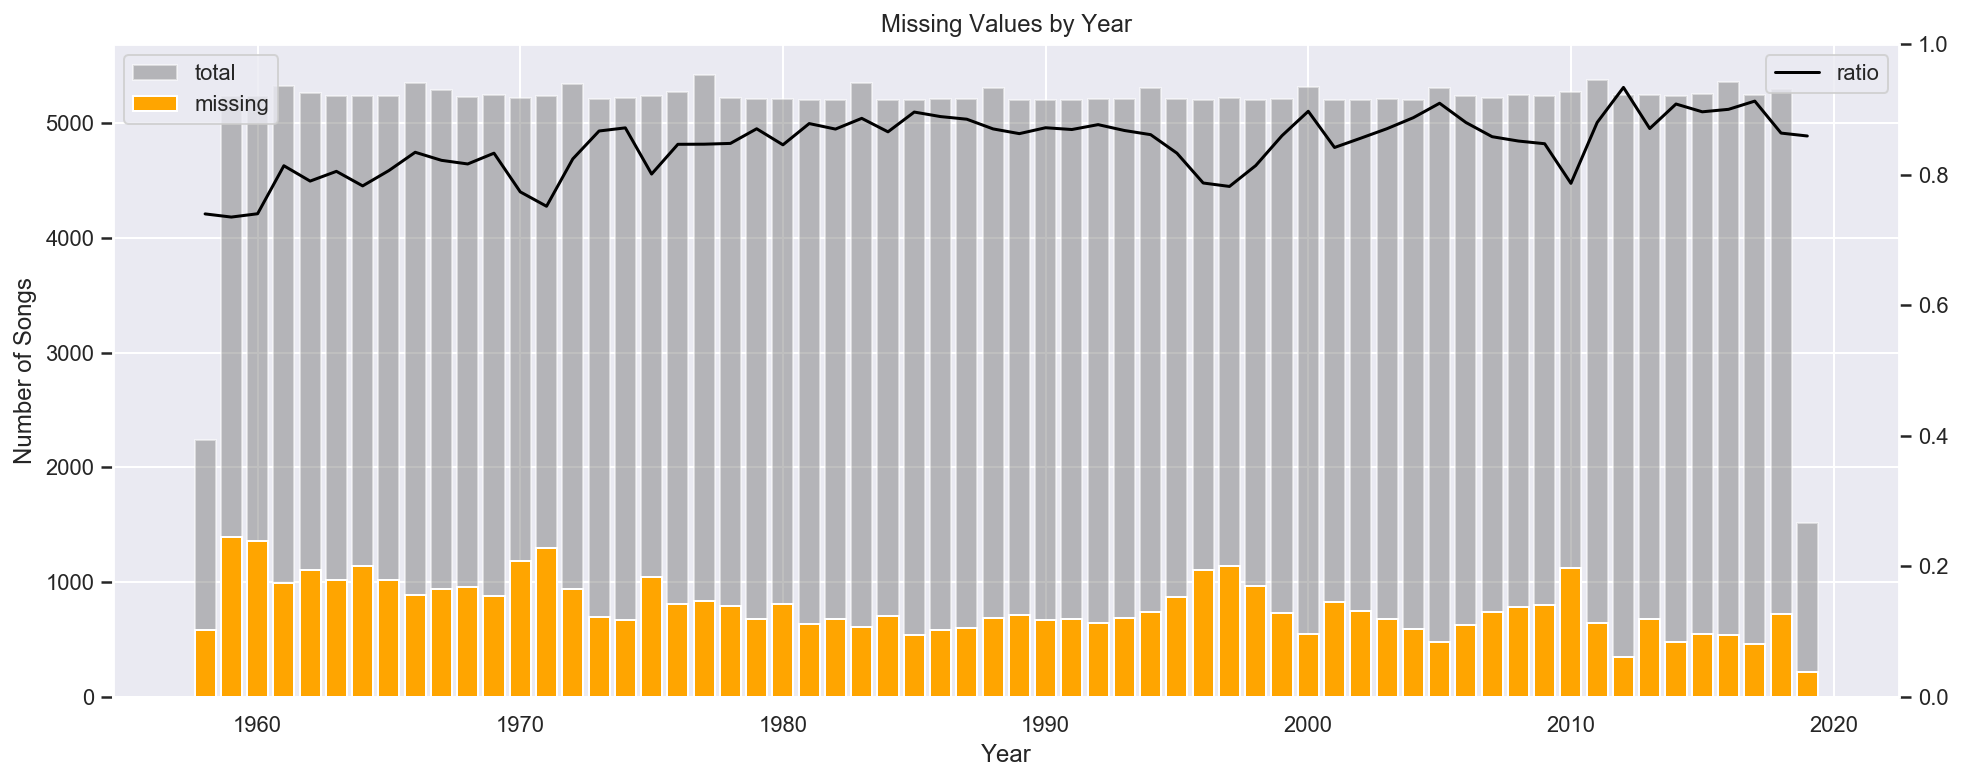

In [25]:
hot100_processed['year'] = hot100_processed.loc[:,'date'].dt.year
hot100_date = hot100_processed.set_index('date')
by_year = hot100_date.groupby(by='year').count().loc[:,['rank','iterator']]
by_year.columns = ['total','complete']
by_year['missing'] = by_year['total'] - by_year['complete']
by_year['ratio'] = by_year['complete'] / by_year['total']

_ = plot_by(x=by_year.index,y=by_year.missing,y_all=by_year.total,y_ratio=by_year.ratio,\
        title='Missing Values by Year',xlabel='Year',ylabel='Number of Songs')

Most missing values are in the late 60s and 70s. The late 80's and early 90's as well as the most recent years show the least amount of missing values but generally the number of missing songs for a year are just below 1/5th (i.e. 20%) for all data, for the periods with higher missing values this number can get close to 1/4th (i.e. 25%).

There are two obvious years that would show incomplete `total` data (e.g. 1958 - the first year - and 2019 - the current year -). Beyond those two years we can see that some years have more than 5200 entries (i.e. 5300 entries). This is due to the fact that the Billboard Hot 100 are released on a Saturday and every so often there are 53 Saturdays in a year (i.e. 1966, 1972, 1977, 1983, etc.).

Lastly, there is slight dip in the years 1976 and 1977 (almost not visible). This is due to missing data on the Billboard Hot 100 charts in the period between 1976-11-22 and 1977-02-28. In this 15 week period exactly one rank/position is missing each week (i.e. 99 songs are on the charts each week for this period). Since this is a minor issue it likely won't affect our model.

In the following we'll check for consistency by rank.

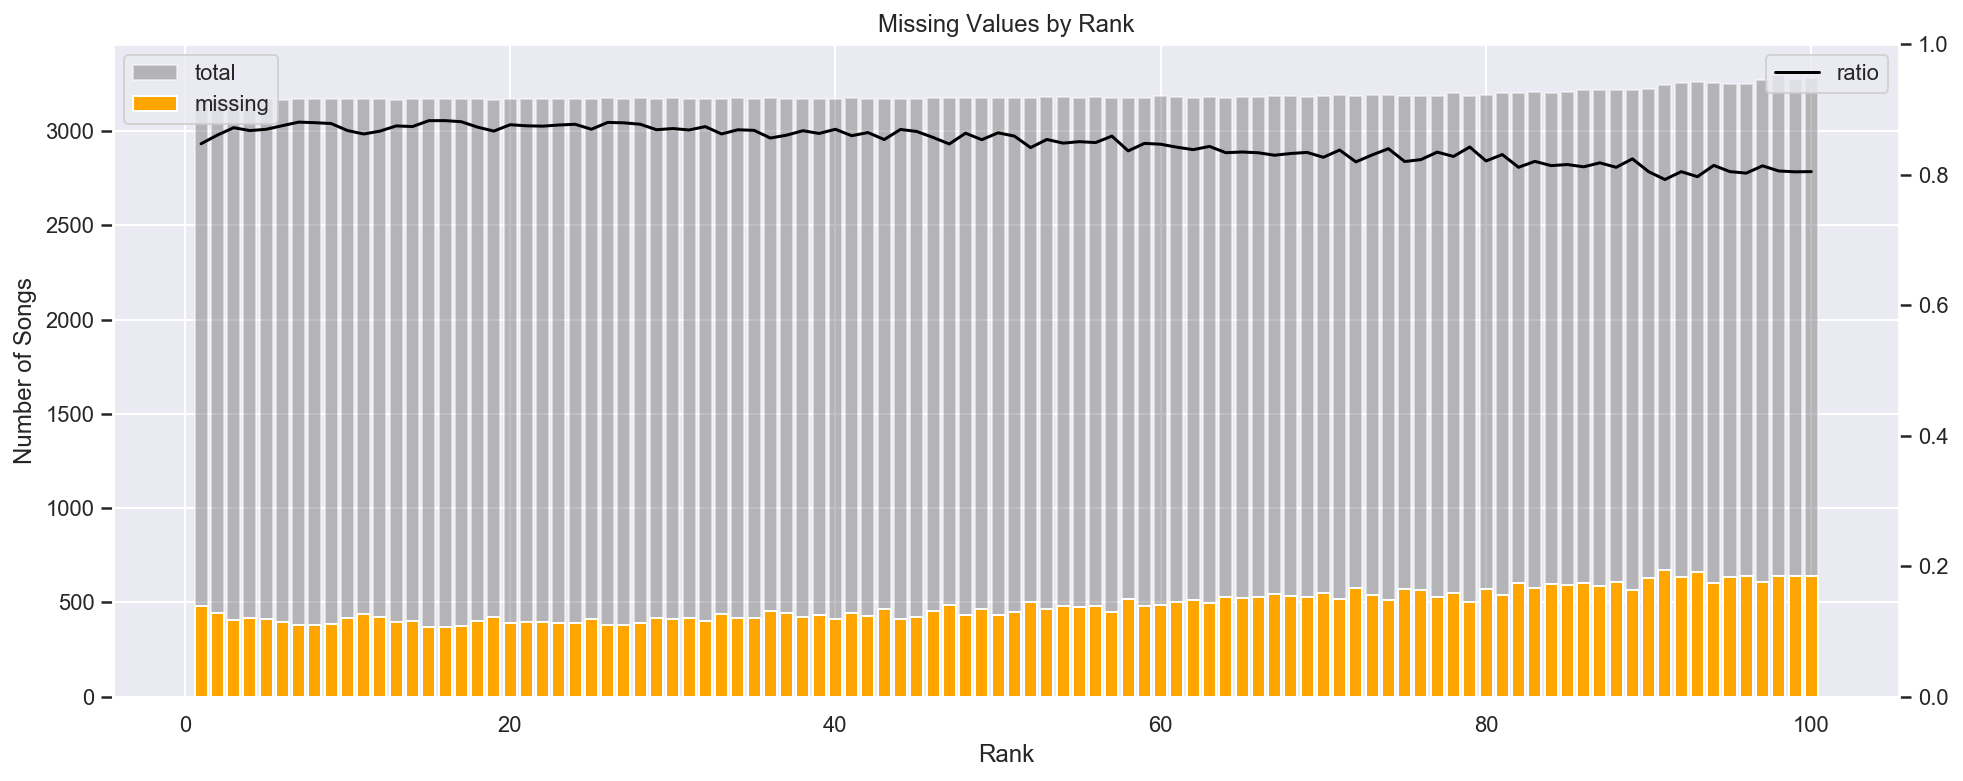

In [26]:
hot100_rank = hot100_processed.set_index('rank')
by_rank = hot100_rank.groupby(by='rank').count().loc[:,['title','iterator']]
by_rank.columns = ['total','complete']
by_rank['missing'] = by_rank['total'] - by_rank['complete']
by_rank['ratio'] = by_rank['complete'] / by_rank['total']

_ = plot_by(x=by_rank.index,y=by_rank.missing,y_all=by_rank.total,y_ratio=by_rank.ratio,\
        title='Missing Values by Rank',xlabel='Rank',ylabel='Number of Songs')

There is no clear trend as to missing values by rank/position. Missing values occur just as often for higher ranks as for lower ranks in our Billboard Hot 100 Charts set. If any trend is visible there might be slightly more missing values towards the lower ranks (toward 100) then in the higher positions, but this trend seems negligible.

Next we'll see how missing values are distributed among unique songs. We'll need to drop any duplicates but since a song can enter and leave at different positions in the Hot 100 chart we'll create a new position identifier that tracks the highest achieved positions (i.e. peak position).

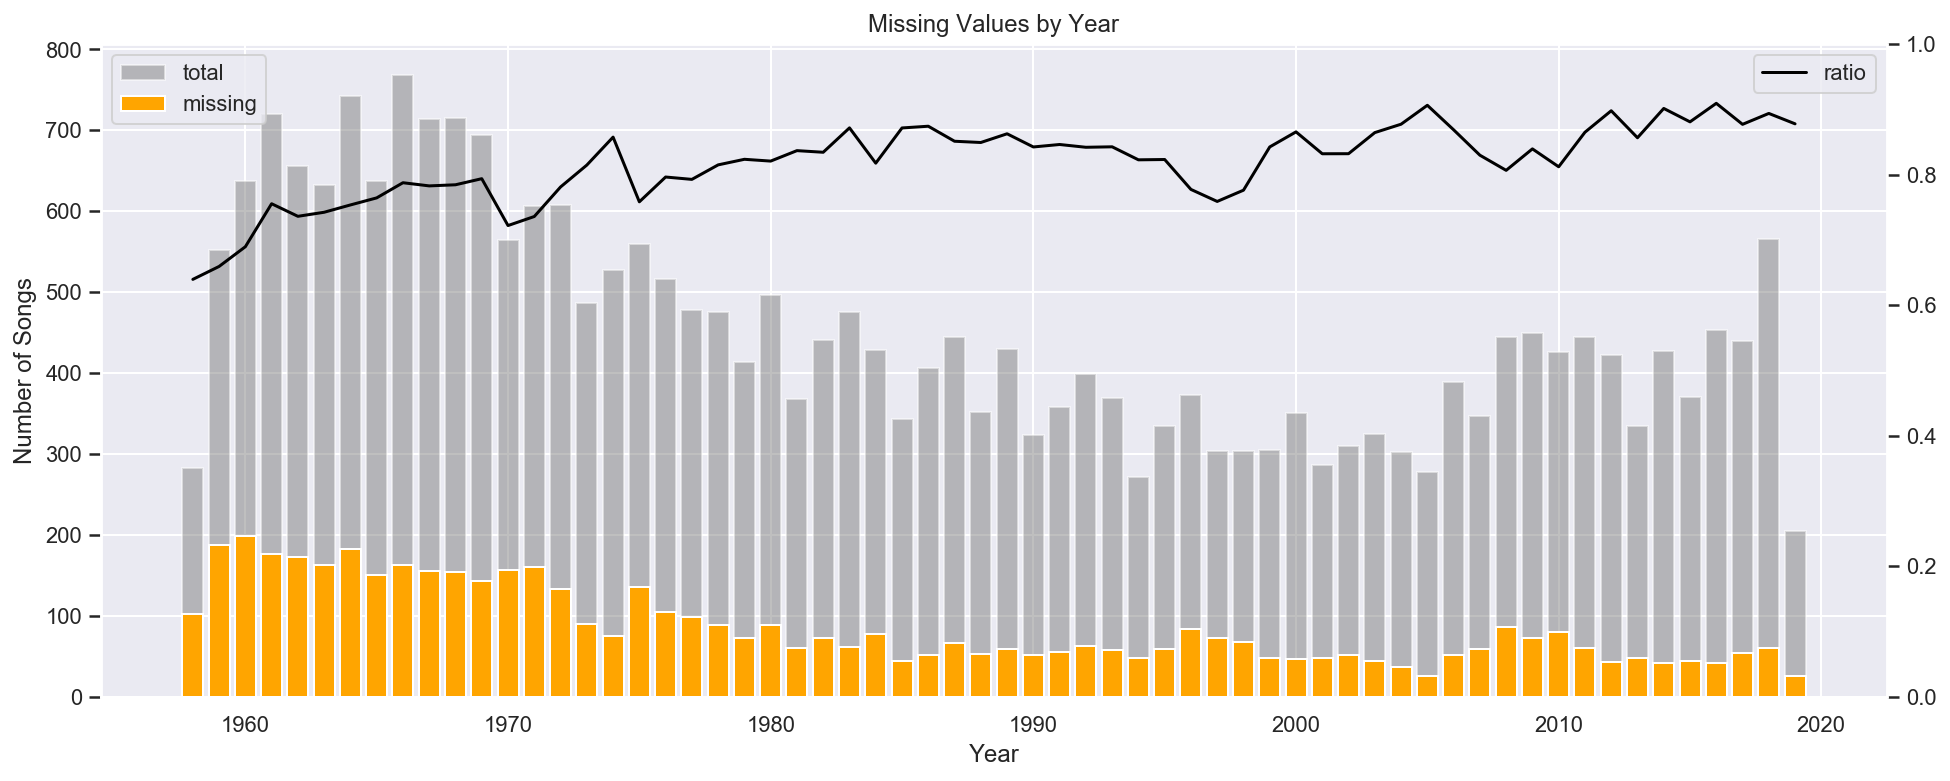

In [27]:
hits_uniq = hot100_processed.drop_duplicates(subset=['artist','title'],keep='first')
hits_uniq = hits_uniq.set_index('date')
by_year_uniq = hits_uniq.groupby(by='year').count().loc[:,['rank','iterator']]
by_year_uniq.columns = ['total','complete']
by_year_uniq['missing'] = by_year_uniq['total'] - by_year_uniq['complete']
# Add a proportion column
by_year_uniq['ratio'] = by_year_uniq['complete'] / by_year_uniq['total']

_ = plot_by(x=by_year_uniq.index,y=by_year_uniq.missing,y_all=by_year_uniq.total,y_ratio=by_year_uniq.ratio,\
        title='Missing Values by Year',xlabel='Year',ylabel='Number of Songs')

Looking at the unique songs, likely the more important metric for our model, we can see a lower number of unique songs in the charts by year in the 90s and early 2000s. This is due to the fact that there is less total fluctuation in the Billboard Hot 100 Charts through time (i.e. songs remain in the charts relatively longer) compared to the 1960s and early 1970s.

That being said we've seen a stagnation of this trend over the past decade with an uptick in recent years (especially 2018).

The overall ratio of complete unique songs to total unique songs ranges between .6 and .9 (i.e. 10% - 40% of songs are missing in any given year). 

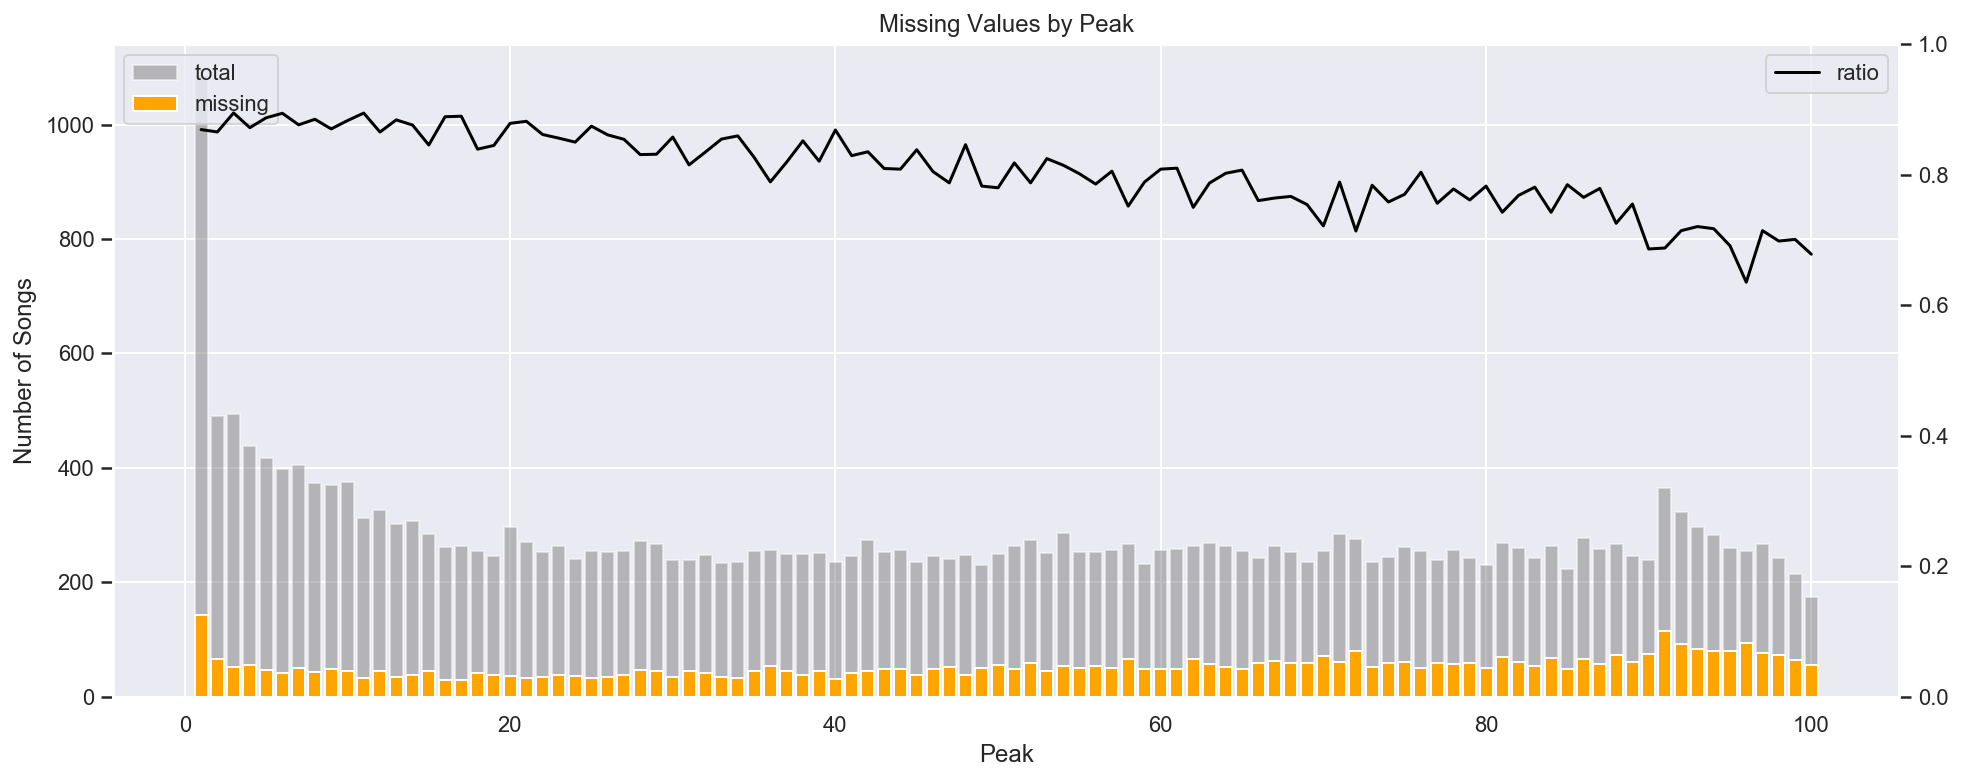

In [28]:
if not 'peak' in hot100_processed.columns:
    peak_ranks = hot100_all.groupby(['title','artist']).min().loc[:,'rank']
    peak_ranks = peak_ranks.rename('peak')
    hot100_processed = hot100_processed.merge(peak_ranks,how='left',on=['title','artist'])

hot100_peak = hot100_processed.sort_values(by=['artist','title','rank'])
hot100_peak = hot100_processed.set_index('peak')
hot100_peak = hot100_processed.drop_duplicates(subset=['artist','title'],keep='first')
by_peak = hot100_peak.groupby(by='peak').count().loc[:,['title','iterator']]
by_peak.columns = ['total','complete']
by_peak['missing'] = by_peak['total'] - by_peak['complete']
by_peak['ratio'] = by_peak['complete'] / by_peak['total']

_ = plot_by(x=by_peak.index,y=by_peak.missing,y_all=by_peak.total,y_ratio=by_peak.ratio,\
        title='Missing Values by Peak',xlabel='Peak',ylabel='Number of Songs')

If we look at the peaks of the unique songs we can see that the pole position (1.) has the most unique songs and hence the most absolute missing values. This shift toward higher positions (lower integers) is expected as the 'peak' feature takes the highest position that was achieved by a song during its time on the hot 100. 

However, looking at the chart proportionally we see a similar trend to the ranks graphs above: the lower positions tend to be less complete than those who've reached higher positions.

As there is little we can do about songs that can't be matched with a Spotify Identifier we unfortunately have to remove those songs from our material.

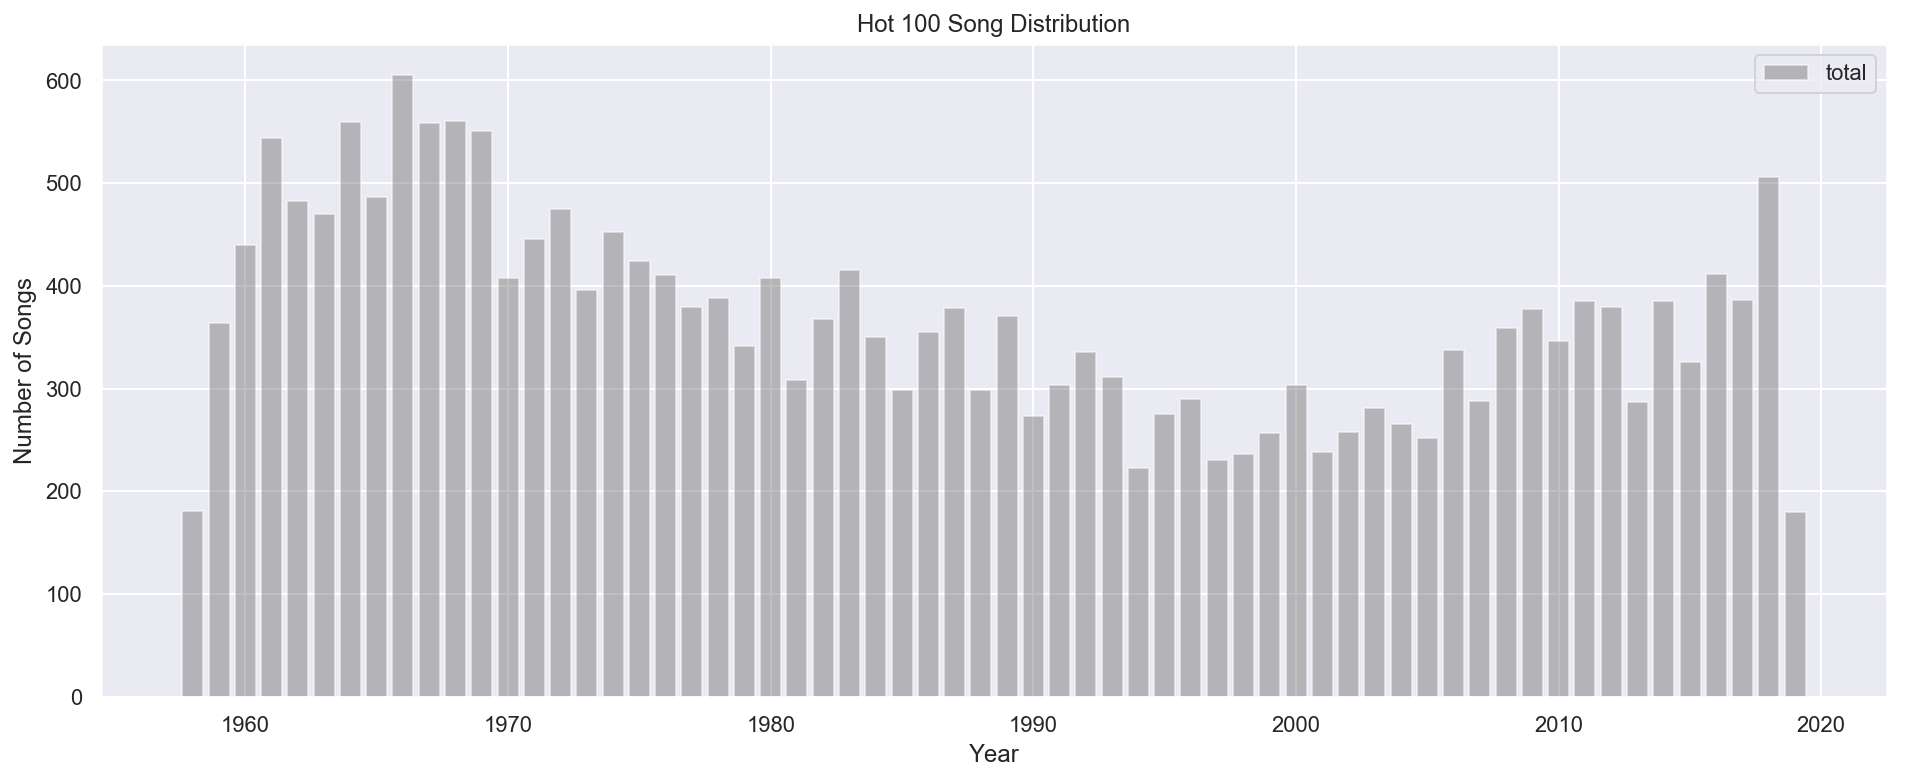

In [29]:
hot100_processed_no_nan = hot100_processed.dropna(subset=['iterator'])
target_columns =['date','year','rank','peak','title','artist','filename','id',
               'danceability','energy', 'key', 'loudness', 'mode', 'speechiness', 
               'acousticness','instrumentalness', 'liveness', 'valence', 'tempo', 
               'duration_ms', 'type', 'uri','track_href', 'analysis_url', 
               'time_signature']
hot100_processed_no_nan = hot100_processed_no_nan.loc[:,target_columns]

hits_uniq = hot100_processed_no_nan.drop_duplicates(subset=['artist','title'],keep='first')
hits_uniq = hits_uniq.drop('rank',axis=1)
hits_uniq = hits_uniq.set_index('date')
hits_uniq_by_year = hits_uniq.groupby(by='year').count().loc[:,['peak','title']]
hits_uniq_by_year.columns = ['total','complete']

_ = plot_single(x=hits_uniq_by_year.index,y=hits_uniq_by_year.total,\
        title='Hot 100 Song Distribution',xlabel='Year',ylabel='Number of Songs')

In [36]:
processed_path = '../processed/'
hits_target = 'hits.csv'
hits_uniq_target = 'hits_uniq.csv'

hot100_processed_no_nan.to_csv(processed_path + hits_target,sep='\t',index=False,encoding='utf-8')

hits_uniq.drop_duplicates(subset=['artist','title'],inplace=True)
hits_uniq.reset_index(inplace=True)
hits_uniq.to_csv(processed_path + hits_uniq_target,sep='\t',index=False,encoding='utf-8')

In [38]:
len(hits_uniq)

22761

In [31]:
hot100_processed_no_nan.head()

,date,year,rank,peak,title,artist,filename,id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,type,uri,track_href,analysis_url,time_signature
0,1967-07-08,1967,1,1,Windy,The Association,./data/interim/hot100/hot100_1967-07-03.csv,6RUpOheT93fUdI508K5w6U,0.677,0.722,5.0,-7.767,1.0,0.0295,0.357,0.148000,0.1050,0.898,132.996,174600.0,audio_features,spotify:track:6RUpOheT93fUdI508K5w6U,https://api.spotify.com/v1/tracks/6RUpOheT93fU...,https://api.spotify.com/v1/audio-analysis/6RUp...,4.0
1,1967-07-08,1967,2,2,Little Bit O' Soul,The Music Explosion,./data/interim/hot100/hot100_1967-07-03.csv,75obkRHfYSwnd20wXMreRO,0.602,0.679,7.0,-6.708,1.0,0.0390,0.337,0.000000,0.3130,0.889,136.459,141827.0,audio_features,spotify:track:75obkRHfYSwnd20wXMreRO,https://api.spotify.com/v1/tracks/75obkRHfYSwn...,https://api.spotify.com/v1/audio-analysis/75ob...,4.0
3,1967-07-08,1967,4,4,San Francisco (Be Sure To Wear Flowers In Your...,Scott McKenzie,./data/interim/hot100/hot100_1967-07-03.csv,77qBwefBIdzymXNCuAI8YX,0.495,0.670,7.0,-5.918,1.0,0.0284,0.047,0.000025,0.2190,0.478,112.443,178933.0,audio_features,spotify:track:77qBwefBIdzymXNCuAI8YX,https://api.spotify.com/v1/tracks/77qBwefBIdzy...,https://api.spotify.com/v1/audio-analysis/77qB...,4.0
4,1967-07-08,1967,5,5,Don't Sleep In The Subway,Petula Clark,./data/interim/hot100/hot100_1967-07-03.csv,1ljijVo7rDHSuXIhydPpNl,0.394,0.486,10.0,-9.742,1.0,0.0366,0.627,0.000000,0.1670,0.427,133.685,175373.0,audio_features,spotify:track:1ljijVo7rDHSuXIhydPpNl,https://api.spotify.com/v1/tracks/1ljijVo7rDHS...,https://api.spotify.com/v1/audio-analysis/1lji...,4.0
5,1967-07-08,1967,6,6,Come On Down To My Boat,Every Mothers' Son,./data/interim/hot100/hot100_1967-07-03.csv,26QAg7zLNAOSKbrslg07Mv,0.600,0.719,10.0,-6.731,1.0,0.0349,0.391,0.000000,0.0221,0.919,127.881,155147.0,audio_features,spotify:track:26QAg7zLNAOSKbrslg07Mv,https://api.spotify.com/v1/tracks/26QAg7zLNAOS...,https://api.spotify.com/v1/audio-analysis/26QA...,4.0


The data distribution by year without missing values resembles roughly the distribution of songs with missing values. Therefore we'll be content with these results for now and are going to divert our attention to the second set of songs that have not made it into the Hot 100.

# Sampling Spotify Data

In the next step we'll generate a sample from Spotify data that roughly resembles the distribution by year we've seen in the Hot 100 data. To capture the breadth of various songs we'll sample ~20% of our spotify songs from the 10% least popular songs on Spotify. This is taking into account that by using the Spotify Search we're only able to sample from the 10000 most popular songs of a year (according to Spotify their popularity score tends to emphasize CURRENT popularity).

To avoid sampling too many overly popular songs we're going to take random samples from the first 10000 search results (in chunks of 50 songs) and we're going to slightly oversample so as to be able to remove the overlap in a later step.

In [93]:
from pprint import pprint
import json
import ast
import spotipy
import random
import math
from spotipy.oauth2 import SpotifyClientCredentials
client_credentials_manager = SpotifyClientCredentials(client_id='e3cddf5da81f43c3a33814866a8de8ed', client_secret='f885f6255fb34c90b8679817d9c63c25')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

def round_up(x, base=50):
    return base * math.ceil(x/base)

target_path = '../interim/spotify_songs.csv'

try:
    sampling_df = pd.read_csv(target_path,sep='\t')
except:
    print('Sampling Songs from Spotify - Beware that a client and secret is necessary for this method.')
    
    output_filepath = '../interim/'
    temp_dir = 'spotify_sampling_temp'
    skip = 0

    if not os.path.exists(output_filepath + temp_dir):
        os.mkdir(output_filepath + temp_dir)
    else:
        for file in iglob(output_filepath + temp_dir + '/*.csv'):
            m = re.search('sampling_([0-9]+?).csv$', file)
            if m:
                file_nr = int(m.group(1))
                if file_nr > skip:
                    skip = file_nr
    
    # Seed random function            
    np.random.seed(500)
    
    # Sampling Additional Songs By Year
    years = sorted(hits_uniq['year'].unique())
    spotify_song_sets = []
    ceil_to = 100
    for i, year in enumerate(years):
        file_nr = i + 1
        if file_nr <= skip:
            print('skip:', file_nr)
            continue
        start = 0
        tracks = []
        len_hot100 = len(hits_uniq.loc[hits_uniq['year'] == year,'year'])
        print(year)
        print("Number of Songs for {}: {}".format(year,len_hot100))
        len_k_tracks = round_up(len_hot100 * 0.8,base=ceil_to)
        k = int(len_k_tracks / 50)
        len_low_k_tracks = round_up(len_hot100 * 0.2,base=ceil_to)
        low_k = int(len_low_k_tracks / 50)
        print("Number of Songs Sampled from high popularity: {}".format(len_k_tracks))
        print("Number of Songs Sampled from low popularity: {}".format(len_low_k_tracks))
        offsets = (x for x in np.random.choice(np.arange(0,10000,50),k,replace=False))
        while len(tracks) < len_k_tracks:
            offset = next(offsets)
            tracks.extend(sp.search(q='year:' + str(year),type='track',limit=50,offset=offset)['tracks']['items'])
        # Fetch Hipster Tags (lowest 10% popularity)
        start = 0
        while (len(tracks) - len_k_tracks) < len_low_k_tracks:
            tracks.extend(sp.search(q='year:' + str(year),type='track',limit=50,offset=start)['tracks']['items'])
            start = start + 50
        time.sleep(3)
        spotify_songs = pd.DataFrame(pd.io.json.json_normalize(tracks))
        
        spotify_songs.to_csv(output_filepath + temp_dir + '/sampling_' + str(file_nr) + '.csv',sep='\t',index=False)
    
    subfiles_sampling = [pd.read_csv(file,sep='\t') for file in iglob(output_filepath + temp_dir + '/sampling_*.csv')]

    sampling_df = pd.concat(subfiles_sampling).reset_index(drop=True)
    sampling_df.to_csv(target_path,sep='\t',index=False)
    
    # Clean up temp files
    [os.remove(file) for file in iglob(output_filepath + temp_dir + '/sampling_*.csv')]
    try:
        os.remove(output_filepath + temp_dir + '/.DS_Store')
    except:
        print('No .DS_Store file. You\'re all set!')

    os.rmdir(output_filepath + temp_dir)

sampling_df.head()

,album.album_type,album.artists,album.available_markets,album.external_urls.spotify,album.href,album.id,album.images,album.name,album.release_date,album.release_date_precision,album.total_tracks,album.type,album.uri,artists,available_markets,disc_number,duration_ms,explicit,external_ids.isrc,external_urls.spotify,href,id,is_local,name,popularity,preview_url,track_number,type,uri
0,album,[{'external_urls': {'spotify': 'https://open.s...,"['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH...",https://open.spotify.com/album/2EBTkU38bcIj3bK...,https://api.spotify.com/v1/albums/2EBTkU38bcIj...,2EBTkU38bcIj3bKWDsx62v,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",Kid Songs Collection,2003-04-01,day,57,album,spotify:album:2EBTkU38bcIj3bKWDsx62v,[{'external_urls': {'spotify': 'https://open.s...,"['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH...",1,98000,False,USA371032351,https://open.spotify.com/track/1OkwKc5MblAbjda...,https://api.spotify.com/v1/tracks/1OkwKc5MblAb...,1OkwKc5MblAbjdaJmlt2Dt,False,This Old Man (Knick Knack Paddy Whack),22,https://p.scdn.co/mp3-preview/da5089bbb5772ad8...,25,track,spotify:track:1OkwKc5MblAbjdaJmlt2Dt
1,album,[{'external_urls': {'spotify': 'https://open.s...,"['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH...",https://open.spotify.com/album/1NI29FCyCorJDx2...,https://api.spotify.com/v1/albums/1NI29FCyCorJ...,1NI29FCyCorJDx2thObZvI,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",La Historia,2003-09-22,day,20,album,spotify:album:1NI29FCyCorJDx2thObZvI,[{'external_urls': {'spotify': 'https://open.s...,"['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH...",1,167440,False,USEL19900345,https://open.spotify.com/track/1OoyICV2I28f05v...,https://api.spotify.com/v1/tracks/1OoyICV2I28f...,1OoyICV2I28f05vpUnJNpe,False,Fiesta En Mi Sepultura,22,NaN,18,track,spotify:track:1OoyICV2I28f05vpUnJNpe
2,album,[{'external_urls': {'spotify': 'https://open.s...,"['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH...",https://open.spotify.com/album/7wLRiapJWwBqDfo...,https://api.spotify.com/v1/albums/7wLRiapJWwBq...,7wLRiapJWwBqDfoDGvTkdY,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",Le Voyage,2003-01-01,day,16,album,spotify:album:7wLRiapJWwBqDfoDGvTkdY,[{'external_urls': {'spotify': 'https://open.s...,"['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH...",1,232755,False,IT00G0343812,https://open.spotify.com/track/1P7DzqwJYocFYNy...,https://api.spotify.com/v1/tracks/1P7DzqwJYocF...,1P7DzqwJYocFYNyrUbq4Zh,False,Le Delire,38,https://p.scdn.co/mp3-preview/1a7046b12a134e06...,12,track,spotify:track:1P7DzqwJYocFYNyrUbq4Zh
3,album,[{'external_urls': {'spotify': 'https://open.s...,"['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH...",https://open.spotify.com/album/2iRDIathSoiD8qw...,https://api.spotify.com/v1/albums/2iRDIathSoiD...,2iRDIathSoiD8qwPChhNnS,"[{'height': 637, 'url': 'https://i.scdn.co/ima...",Glenn Miller And The Andrews Sisters: The Ches...,2003-06-26,day,39,album,spotify:album:2iRDIathSoiD8qwPChhNnS,[{'external_urls': {'spotify': 'https://open.s...,"['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH...",2,197200,False,USBB19900298,https://open.spotify.com/track/1RHUeOzrvezRbwj...,https://api.spotify.com/v1/tracks/1RHUeOzrvezR...,1RHUeOzrvezRbwjimJDWbj,False,The Woodpecker Song (Reginella Campagnola),24,https://p.scdn.co/mp3-preview/0b7824dfb17760fa...,6,track,spotify:track:1RHUeOzrvezRbwjimJDWbj
4,album,[{'external_urls': {'spotify': 'https://open.s...,"['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH...",https://open.spotify.com/album/1PIRZ0Jl3VoymYG...,https://api.spotify.com/v1/albums/1PIRZ0Jl3Voy...,1PIRZ0Jl3VoymYGIsqsKMz,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",Bringer of Blood,2003,year,11,album,spotify:album:1PIRZ0Jl3VoymYGIsqsKMz,[{'external_urls': {'spotify': 'https://open.s...,"['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH...",1,180666,False,USMBR0501875,https://open.spotify.com/track/1VcHAep7KMHBqze...,https://api.spotify.com/v1/tracks/1VcHAep7KMHB...,1VcHAep7KMHBqze6pxxNN0,False,Amerika The Brutal,28,htt

In [94]:
# Create String of artists
sampling_df['artist_name'] = [' + '.join([artist['name'] for artist in ast.literal_eval(artists)]) for artists in sampling_df['artists']]
sampling_df['album.release_date'] = pd.to_datetime(sampling_df['album.release_date'])
sampling_df['year'] = sampling_df['album.release_date'].dt.year
spotify_songs = sampling_df.loc[:,['id','name','artist_name','album.id','album.name','year','album.release_date','duration_ms','popularity','uri']]
spotify_songs.head()

,id,name,artist_name,album.id,album.name,year,album.release_date,duration_ms,popularity,uri
0,1OkwKc5MblAbjdaJmlt2Dt,This Old Man (Knick Knack Paddy Whack),The Kiboomers,2EBTkU38bcIj3bKWDsx62v,Kid Songs Collection,2003,2003-04-01,98000,22,spotify:track:1OkwKc5MblAbjdaJmlt2Dt
1,1OoyICV2I28f05vpUnJNpe,Fiesta En Mi Sepultura,Los Originales De San Juan,1NI29FCyCorJDx2thObZvI,La Historia,2003,2003-09-22,167440,22,spotify:track:1OoyICV2I28f05vpUnJNpe
2,1P7DzqwJYocFYNyrUbq4Zh,Le Delire,Floorfilla,7wLRiapJWwBqDfoDGvTkdY,Le Voyage,2003,2003-01-01,232755,38,spotify:track:1P7DzqwJYocFYNyrUbq4Zh
3,1RHUeOzrvezRbwjimJDWbj,The Woodpecker Song (Reginella Campagnola),The Andrews Sisters + Glenn Miller Orchestra,2iRDIathSoiD8qwPChhNnS,Glenn Miller And The Andrews Sisters: The Ches...,2003,2003-06-26,197200,24,spotify:track:1RHUeOzrvezRbwjimJDWbj
4,1VcHAep7KMHBqze6pxxNN0,Amerika The Brutal,Six Feet Under,1PIRZ0Jl3VoymYGIsqsKMz,Bringer of Blood,2003,2003-01-01,180666,28,spotify:track:1VcHAep7KMHBqze6pxxNN0


In [95]:
# Remove Songs that are also in the Hot 100
nhits = spotify_songs.loc[~spotify_songs['id'].isin(hot100_processed['iterator']),:]
overlap = spotify_songs.loc[spotify_songs['id'].isin(hot100_processed['iterator']),:]
print("{} Songs had to be removed as they overlap with Hot 100 Data".format(len(overlap)))

3764 Songs had to be removed as they overlap with Hot 100 Data


Total Spotify Songs: 22836
Total Hot 100 Songs: 22761
Spotify to Hot 100 ratio: 1.0033
Spotify/Total: 50.080000000000005%


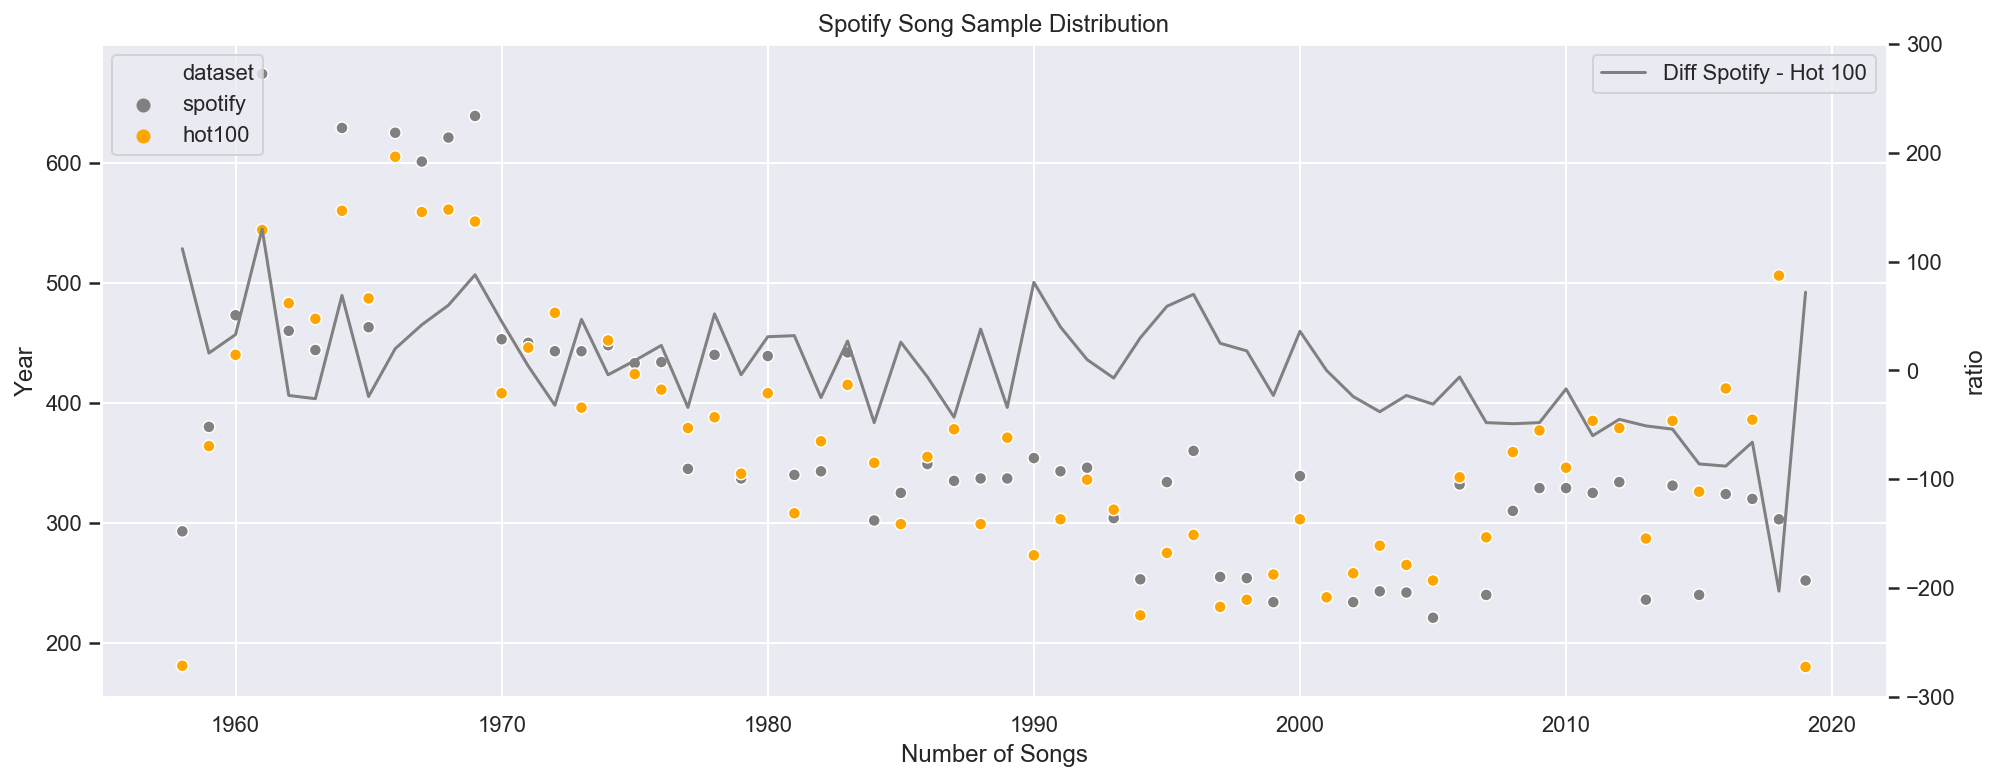

In [103]:
years = len(nhits['year'].unique())
spotify_uniq_by_year = nhits.groupby(by='year').count()

fig = plt.figure(figsize=(16,6))
data=pd.concat([spotify_uniq_by_year['id'],hits_uniq_by_year['total']],axis=1)
data.columns = ['spotify','hot100']

data_ratio = pd.DataFrame(index=data.index)
data_ratio['ratio'] = (data['spotify'] - data['hot100'])
data_ratio.reset_index(inplace=True)

data.reset_index(inplace=True)
data = data.melt(id_vars=['year'])
data.columns = ['year','dataset','value']

title='Spotify Song Sample Distribution'
ylabel='Year'
xlabel='Number of Songs'

_ = sns.scatterplot(x='year',y='value',hue='dataset',data=data)
_ = plt.title(title)
_ = plt.xlabel(xlabel)
_ = plt.ylabel(ylabel)
_ = plt.legend(loc='upper left')
_ = plt.twinx()
_ = sns.lineplot(x='year',y='ratio',data=data_ratio,label='Diff Spotify - Hot 100')
_ = plt.legend(loc='upper right')
_ = plt.yticks(np.arange(-300,350,100))
_ = plt.grid(False)

total_spotify = data.loc[data['dataset'] == 'spotify','value'].sum()
total_hot100 = data.loc[data['dataset'] == 'hot100','value'].sum()
print("Total Spotify Songs: {}\nTotal Hot 100 Songs: {}\nSpotify to Hot 100 ratio: {}\nSpotify/Total: {}%".format(total_spotify,total_hot100,round(total_spotify/total_hot100,4),round(total_spotify/(total_spotify+total_hot100),4)*100))

The above graph shows the Spotify Sample compared to the Hot 100 Data. We can see that the two datasets are almost equally distributed. The Line Graph ("Diff Spotify Hot 100") shows absolute count differences between Spotify and the Hot 100 Data and we can see that the Spotify song set is minimally larger (i.e. Spotify songs make up 50.08% of all songs).

In [104]:
# Create Iterator for data set 
spotify_songs_iterator = nhits.drop_duplicates()['id'].to_frame()
spotify_songs_iterator.columns = ['iterator']
spotify_songs_iterator.to_csv('../iterators/spotify_songs_ids_iterator.csv',sep='\t',index=False,encoding='utf-8')

The above code outputs an iterator csv for scraping the spotify features for our non-hits (spotify sample). Which we're going to read into a DataFrame below for creating the processed file.

In [105]:
# Read in all Subfiles
filenames = glob('comparison_data_analysis_api/*.csv')
nhits_analysis_dfs = [pd.read_csv(filepath,sep='\t') for filepath in filenames]
nhits_analysis_all = pd.concat(nhits_analysis_dfs,sort=True)
nhits_analysis_all = nhits_analysis_all.drop(['duration_ms','uri'],axis=1)
nhits_analysis_all.rename(columns={'name':'iterator'}, inplace=True)
nhits_analysis_all.head()

nhits_processed = nhits.merge(nhits_analysis_all,on=['id'],how='left')
print("Length of all nhits and merged nhits_processed match: {} ({})".format(len(nhits_processed) == len(nhits),len(nhits_processed)))

Length of all nhits and merged nhits_processed match: True (22836)


In [106]:
nhits_processed.loc[nhits_processed['tempo'].isnull(),:]

,id,name,artist_name,album.id,album.name,year,album.release_date,duration_ms,popularity,uri,acousticness,analysis_url,danceability,energy,instrumentalness,key,liveness,loudness,mode,iterator,speechiness,tempo,time_signature,track_href,type,valence
9584,5FRi2yvpA5wQPqGeujn4Tt,Act of being polite,The Residents,6VEns9PXETPgZdZXMAZzvg,The Commercial Album,1980,1980-01-01,66586,10,spotify:track:5FRi2yvpA5wQPqGeujn4Tt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [107]:
target_columns = ['year','name','artist_name','popularity','id','album.id','album.name',
                    'album.release_date','danceability','energy','key','loudness','mode',
                    'speechiness','acousticness','instrumentalness','liveness','valence',
                    'tempo','duration_ms','type','uri','track_href','analysis_url','time_signature']
nhits_processed = nhits_processed.loc[:,target_columns]
nhits_processed.columns

Index(['year', 'name', 'artist_name', 'popularity', 'id', 'album.id',
       'album.name', 'album.release_date', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_ms', 'type', 'uri',
       'track_href', 'analysis_url', 'time_signature'],
      dtype='object')

In [108]:
nhits_processed.head()

,year,name,artist_name,popularity,id,album.id,album.name,album.release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,type,uri,track_href,analysis_url,time_signature
0,2003,This Old Man (Knick Knack Paddy Whack),The Kiboomers,22,1OkwKc5MblAbjdaJmlt2Dt,2EBTkU38bcIj3bKWDsx62v,Kid Songs Collection,2003-04-01,0.958,0.337,0.0,-7.761,1.0,0.0592,0.21200,0.0000,0.0832,0.914,125.904,98000,audio_features,spotify:track:1OkwKc5MblAbjdaJmlt2Dt,https://api.spotify.com/v1/tracks/1OkwKc5MblAb...,https://api.spotify.com/v1/audio-analysis/1Okw...,4.0
1,2003,Fiesta En Mi Sepultura,Los Originales De San Juan,22,1OoyICV2I28f05vpUnJNpe,1NI29FCyCorJDx2thObZvI,La Historia,2003-09-22,0.531,0.720,2.0,-5.290,1.0,0.1500,0.58800,0.0000,0.0282,0.890,81.728,167440,audio_features,spotify:track:1OoyICV2I28f05vpUnJNpe,https://api.spotify.com/v1/tracks/1OoyICV2I28f...,https://api.spotify.com/v1/audio-analysis/1Ooy...,3.0
2,2003,Le Delire,Floorfilla,38,1P7DzqwJYocFYNyrUbq4Zh,7wLRiapJWwBqDfoDGvTkdY,Le Voyage,2003-01-01,0.706,0.944,5.0,-6.156,1.0,0.0317,0.00234,0.2630,0.3220,0.460,137.996,232755,audio_features,spotify:track:1P7DzqwJYocFYNyrUbq4Zh,https://api.spotify.com/v1/tracks/1P7DzqwJYocF...,https://api.spotify.com/v1/audio-analysis/1P7D...,4.0
3,2003,The Woodpecker Song (Reginella Campagnola),The Andrews Sisters + Glenn Miller Orchestra,24,1RHUeOzrvezRbwjimJDWbj,2iRDIathSoiD8qwPChhNnS,Glenn Miller And The Andrews Sisters: The Ches...,2003-06-26,0.740,0.341,0.0,-11.338,1.0,0.0870,0.89200,0.0000,0.8070,0.604,97.226,197200,audio_features,spotify:track:1RHUeOzrvezRbwjimJDWbj,https://api.spotify.com/v1/tracks/1RHUeOzrvezR...,https://api.spotify.com/v1/audio-analysis/1RHU...,4.0
4,2003,Amerika The Brutal,Six Feet Under,28,1VcHAep7KMHBqze6pxxNN0,1PIRZ0Jl3VoymYGIsqsKMz,Bringer of Blood,2003-01-01,0.490,0.965,7.0,-4.693,1.0,0.0586,0.00438,0.0042,0.1280,0.460,92.005,180666,audio_features,spotify:track:1VcHAep7KMHBqze6pxxNN0,https://api.spotify.com/v1/tracks/1VcHAep7KMHB...,https://api.spotify.com/v1/audio-analysis/1VcH...,4.0


In [109]:
nhits_processed_no_nan = nhits_processed.dropna(subset=['analysis_url']).drop_duplicates(subset=['id'])
print(len(nhits_processed_no_nan))
processed_path = '../processed/'
nhits_target = 'nhits_uniq.csv'
nhits_processed_no_nan.to_csv(processed_path + nhits_target,sep='\t',index=False,encoding='utf-8')

22702
